In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Load and Show dataset Size

In [4]:
# File path to the CSV dataset
file_path = '/home/ashu/CSE_558_Project/data/initial_data.csv'  # Update with your CSV file path

sampled_chunks = []

chunk_size = 100000

for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
    sampled_chunk = chunk.sample(frac=0.01, random_state=42)
    sampled_chunks.append(sampled_chunk)

df = pd.concat(sampled_chunks)

print(f'Sample size: {len(df)} rows')
print(df.head())

# Check the size of the DataFrame
num_rows, num_cols = df.shape
total_elements = num_rows * num_cols
print(f"Initial dataset size: {num_rows} rows, {num_cols} columns, {total_elements} total elements.")

Sample size: 48941 rows
             id                                              title    year  \
75721  68718114  Learning Problem-Solving Heuristics Through Pr...  1981.0   
80184  72661655  A Web-Enabled System for Storage and Retrieval...  2001.0   
19864  17817017  Improving phonotactic language recognition wit...  2007.0   
76699  69465617  Security Policy Management in Distributed Syst...  2002.0   
92991  84230433          LODr - A Linking Open Data Tagging System  2008.0   

                         author_name  \
75721                nan;nan;nan;nan   
80184        nan;nan;nan;nan;nan;nan   
19864  Wade Shen;Douglas A. Reynolds   
76699                    nan;nan;nan   
92991                            NaN   

                                              author_org  \
75721                                    nan;nan;nan;nan   
80184                            nan;nan;nan;nan;nan;nan   
19864  massachusetts institute of technology;massachu...   
76699                     

# Checking for noise in the data Using EDA

In [9]:
df

,id,title,year,author_name,author_org,author_id,n_citation,doc_type,reference_count,references,...,venue_name,venue_type,doi,keyword,volume,issue,publisher,weight,indexed_keyword,inverted_index
75721,68718114,Learning Problem-Solving Heuristics Through Pr...,1981.0,nan;nan;nan;nan,nan;nan;nan;nan,nan;nan;nan;nan,69.0,Conference,NaN,NaN,...,International Joint Conference on Artificial I...,C,NaN,Algorithmic learning theory;Instance-based lea...,NaN,NaN,NaN,0.73865;0.7147;0.46458;0.63496;0.60619;0.0;0.0...,NaN,NaN
80184,72661655,A Web-Enabled System for Storage and Retrieval...,2001.0,nan;nan;nan;nan;nan;nan,nan;nan;nan;nan;nan;nan,nan;nan;nan;nan;nan;nan,NaN,Conference,NaN,NaN,...,"World Multiconference on Systemics, Cybernetic...",C,NaN,Information retrieval;Data retrieval;Computer ...,NaN,NaN,IIIS,0.45906;0.717;0.4172;0.43753,NaN,NaN
19864,17817017,Improving phonotactic language recognition wit...,2007.0,Wade Shen;Douglas A. Reynolds,massachusetts institute of technology;massachu...,2108328504;2121974799,17.0,Conference,13.0,141449985;156922528;1989124352;2002342963;2099...,...,Conference of the International Speech Communi...,C,NaN,Tokenization (data security);Phonotactics;Comp...,NaN,NaN,NaN,0.52728;0.46315;0.40889;0.40519;0.47202;0.0;0....,recognition;language;research;these;normalize;...,"[6, 66];[5, 65];[54];[19, 31, 72];[56];[59];[3..."
76699,69465617,Security Policy Management in Distributed Syst...,2002.0,nan;nan;nan,nan;nan;nan,nan;nan;nan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Security convergence;Network security policy;C...,NaN,NaN,NaN,0.82017;0.73843;0.48004;0.74073;0.4322;0.73826...,NaN,NaN
92991,84230433,LODr - A Linking Open Data Tagging System,2008.0,NaN,NaN,NaN,7.0,NaN,2.0,2119662395;2169327824,...,NaN,NaN,NaN,Open data;World Wide Web;Information retrieval...,NaN,NaN,CEUR-WS.org,0.53918;0.46356;0.45619;0.42088;0.62126;0.5944...,"providing;introduces;LODr,;for;demo;content;fe...",[7];[3];[4];[10];[1];[13];[9];[24];[2];[12];[2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4892532,94093455,Meta-evolution Modelling: Beyond Selection/Mut...,2013.0,Mariusz Nowostawski,"University of Otago,",1279364522,NaN,NaN,11.0,159262212;1531193245;1593113934;1593481303;159...,...,NaN,NaN,https://doi.org/10.1007/978-3-642-34300-1_24,Virtual machine;Computer science;Artificial in...,NaN,NaN,"Springer, Berlin, Heidelberg",0.4586;0.43843;0.4479;0.52567;0.6309;0.43025,called;(biological);shift;own;do;approach;mech...,"[103];[56];[29];[95];[42];[10, 87];[58];[90];[..."
4832109,2616078511,Sublogarithmic Distributed Algorithms for Lov'...,2017.0,nan;nan,nan;nan,nan;nan,23.0,Repository,11.0,1989381030;2016602690;2023634316;2112009244;21...,...,arXiv: Data Structures and Algorithms,J,NaN,Randomized algorithm;Discrete mathematics;Bina...,NaN,NaN,NaN,0.46025;0.44919;0.43335;0.45361;0.46603;0.4055...,(on;upper;$\Omega(\log\log;problem;coloring;re...,"[29];[71];[91];[148];[183];[17];[39, 126, 144]..."
4893672,981523069,Cross-pose Face Recognition by Canonical Corre...,2015.0,nan;nan;nan;nan;nan;nan,nan;nan;nan;nan;nan;nan,nan;nan;nan;nan;nan;nan,2.0,Repository,45.0,62997892;1989702938;2001565863;2006793117;2024...,...,arXiv: Computer Vision and Pattern Recognition,J,NaN,Facial recognition system;Feature vector;Subsp...,NaN,NaN,NaN,0.5793;0.59029;0.50321;0.47085;0.42461;0.51987...,pose-invariance;experimental;approach;via;prob...,"[108];[114];[119];[57];[2, 21, 42];[82];[34];[..."
4821286,2578406093,On the m -clustering Problem on the Line.,2016.0,nan;nan,nan;nan,nan;nan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Pattern recognition;Computer science;Artificia...,NaN,NaN,NaN,0.41771;0.37012;0.0;0.74332,NaN,NaN


In [10]:
df_sampled = df.sample(n=10000, random_state=42)

In [14]:
def perform_eda(df):
    """
    Performs Exploratory Data Analysis to identify and visualize noise in the dataset.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    """
    # Display basic information about the dataset
    print("Dataset Information:")
    print(df.info())
    print("\n")

    # Display summary statistics
    print("Summary Statistics:")
    print(df.describe(include='all'))
    print("\n")

    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing Values per Column:")
    print(missing_values)
    print("\n")

    # Visualize missing data
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Values')
    plt.show()
    print("The heatmap above shows the distribution of missing values across the dataset. Columns with more missing values will have more yellow lines.")

    # Visualize the distribution of numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        plt.figure(figsize=(12, 6))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
        print(f"The histogram above shows the distribution of '{col}'. Skewness or irregularities may indicate noise.")

        # Boxplot to detect outliers
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()
        print(f"The boxplot above for '{col}' helps identify outliers. Points outside the whiskers are potential outliers.")

        # Outlier Detection using IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            print(f"No variation in '{col}'; skipping outlier detection.\n")
            continue
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers = outliers.shape[0]
        print(f"Number of outliers in '{col}': {num_outliers}\n")

    # Visualize correlations between numerical variables
    if len(numeric_cols) >= 2:
        plt.figure(figsize=(12, 6))
        corr_matrix = df[numeric_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix of Numerical Variables')
        plt.show()
        print("The correlation matrix above shows the correlation coefficients between numerical variables. High correlations may indicate multicollinearity.")

    # Check for duplicates
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")
    if num_duplicates > 0:
        print("There are duplicate rows in the dataset, indicating data redundancy or duplication.\n")
    else:
        print("There are no duplicate rows in the dataset.\n")

    # Analyze categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        num_unique_values = df[col].nunique()
        print(f"Categorical Variable '{col}' has {num_unique_values} unique values.")
        if num_unique_values < 20:
            unique_values = df[col].unique()
            print(f"Unique values in '{col}': {unique_values}\n")
        else:
            print(f"'{col}' has many unique values; we should consider checking for inconsistencies or encoding if necessary.\n")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 48941 entries, 75721 to 4820928
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               48941 non-null  int64  
 1   title            48941 non-null  object 
 2   year             48941 non-null  float64
 3   author_name      46261 non-null  object 
 4   author_org       46261 non-null  object 
 5   author_id        46261 non-null  object 
 6   n_citation       35431 non-null  float64
 7   doc_type         43982 non-null  object 
 8   reference_count  37784 non-null  float64
 9   references       37784 non-null  object 
 10  venue_id         43733 non-null  float64
 11  venue_name       43733 non-null  object 
 12  venue_type       43733 non-null  object 
 13  doi              39306 non-null  object 
 14  keyword          48795 non-null  object 
 15  volume           21928 non-null  float64
 16  issue            16307 non-null  flo

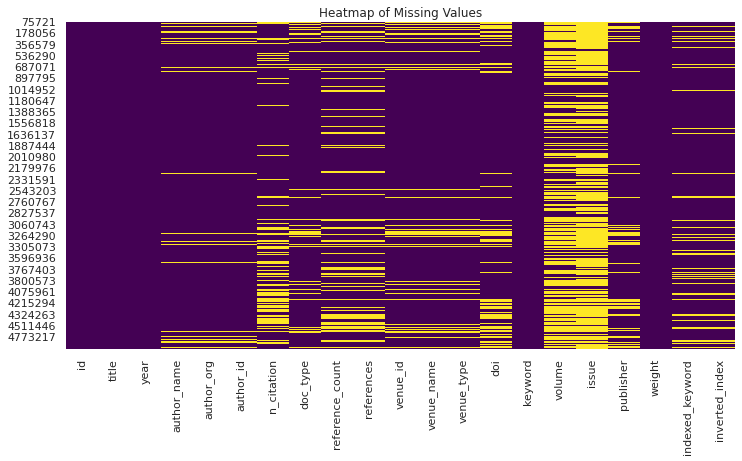

The heatmap above shows the distribution of missing values across the dataset. Columns with more missing values will have more yellow lines.


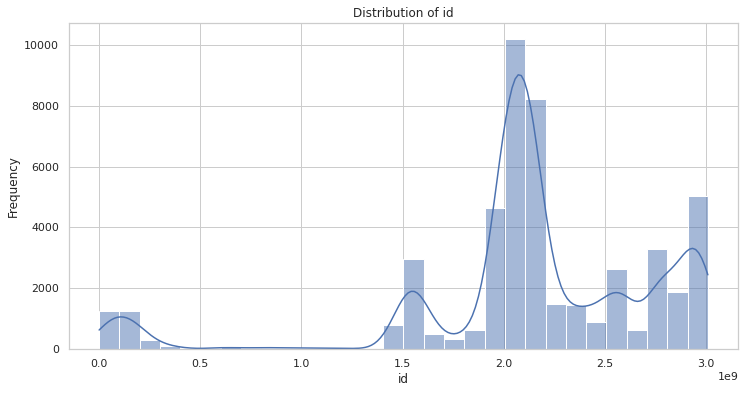

The histogram above shows the distribution of 'id'. Skewness or irregularities may indicate noise.


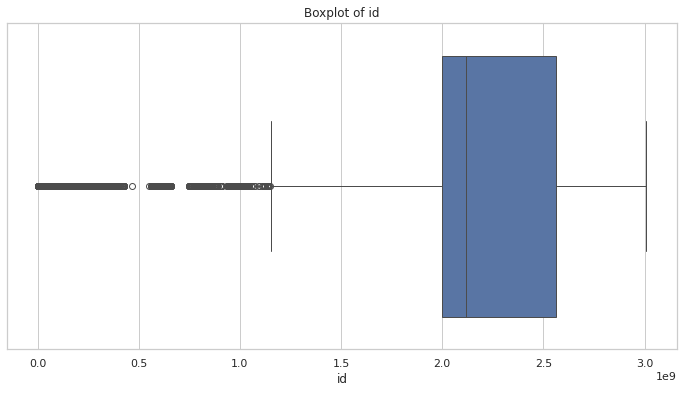

The boxplot above for 'id' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'id': 3250



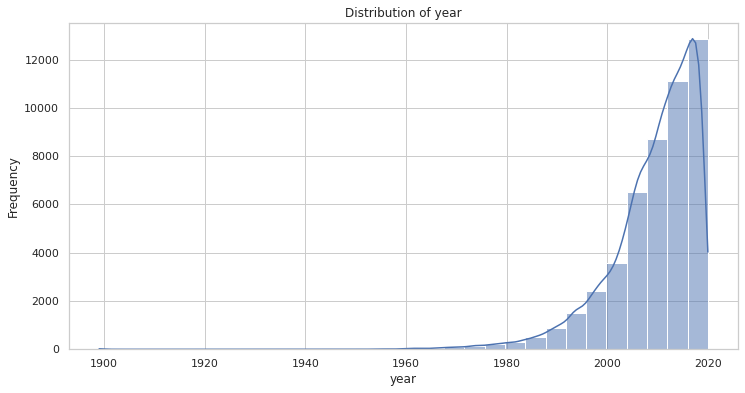

The histogram above shows the distribution of 'year'. Skewness or irregularities may indicate noise.


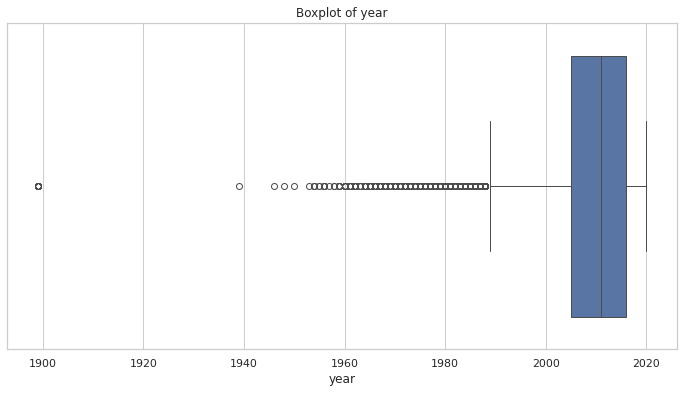

The boxplot above for 'year' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'year': 1536



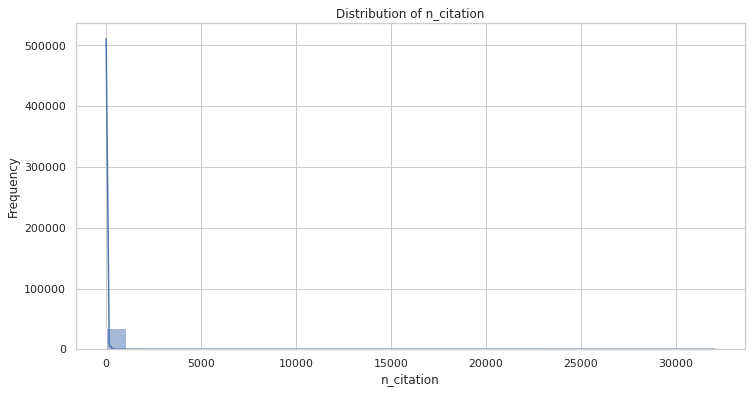

The histogram above shows the distribution of 'n_citation'. Skewness or irregularities may indicate noise.


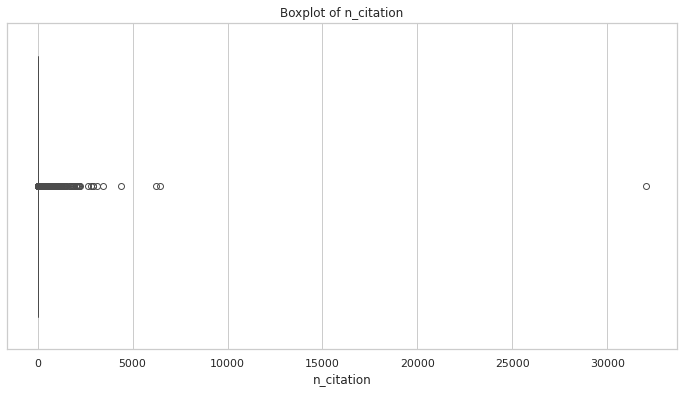

The boxplot above for 'n_citation' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'n_citation': 4110



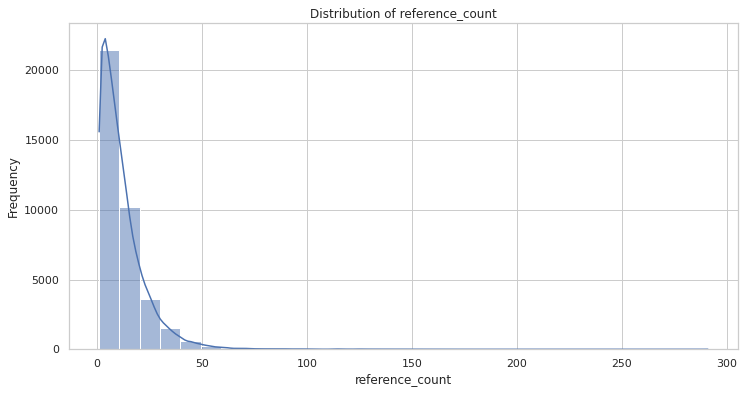

The histogram above shows the distribution of 'reference_count'. Skewness or irregularities may indicate noise.


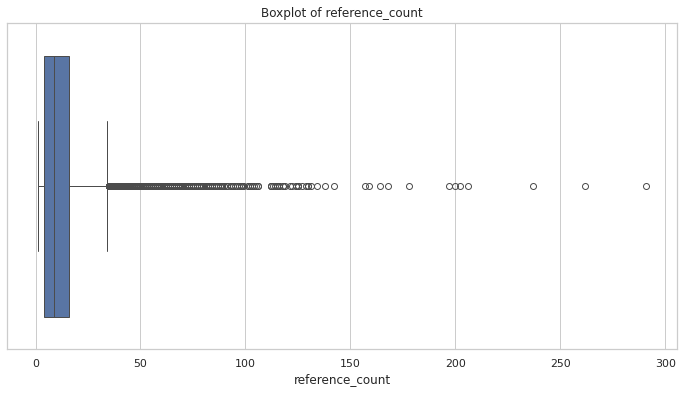

The boxplot above for 'reference_count' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'reference_count': 1646



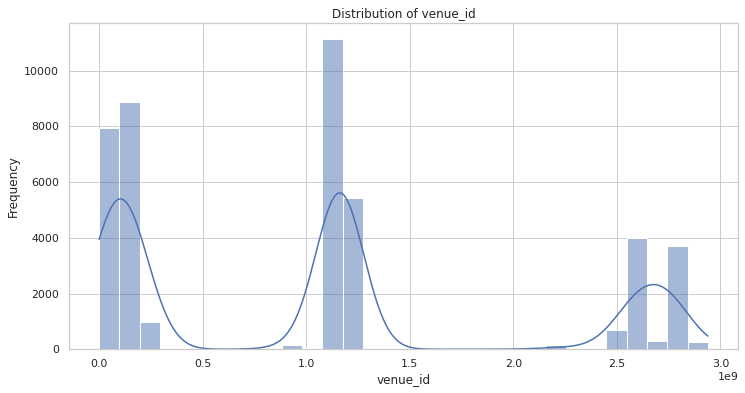

The histogram above shows the distribution of 'venue_id'. Skewness or irregularities may indicate noise.


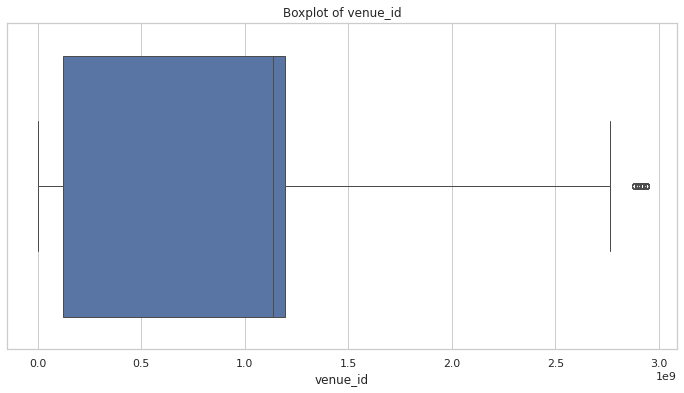

The boxplot above for 'venue_id' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'venue_id': 250



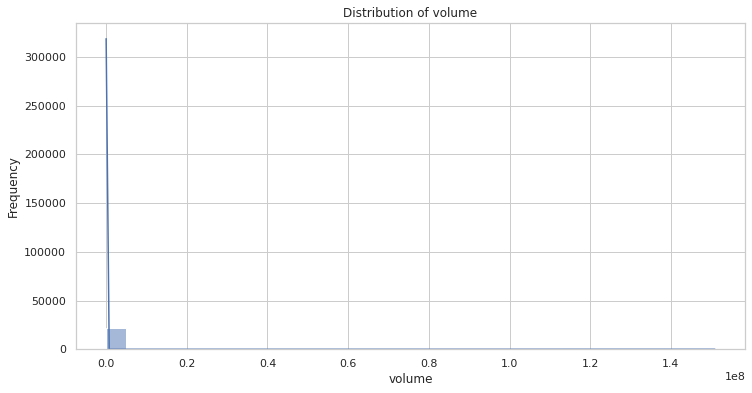

The histogram above shows the distribution of 'volume'. Skewness or irregularities may indicate noise.


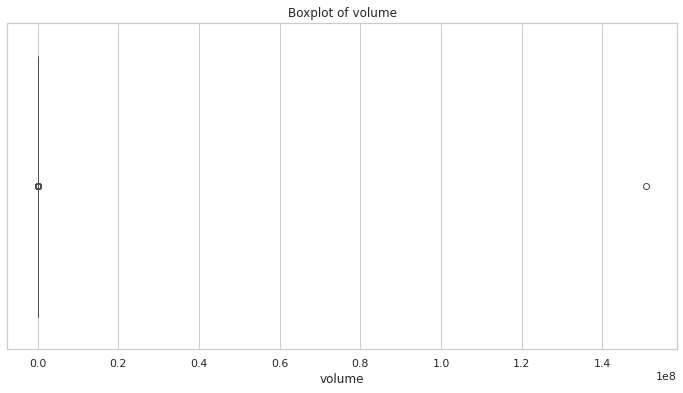

The boxplot above for 'volume' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'volume': 2840



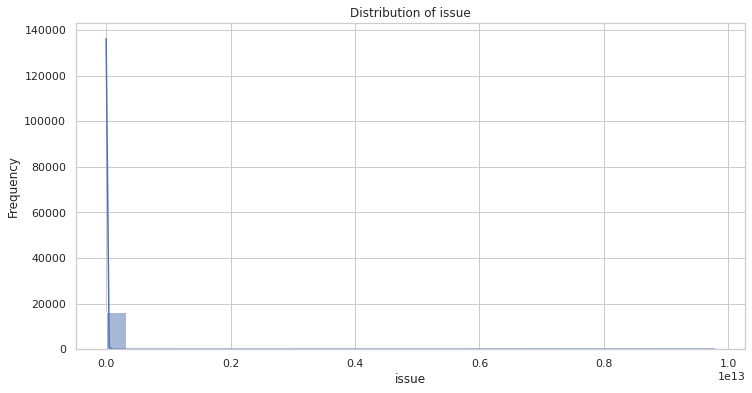

The histogram above shows the distribution of 'issue'. Skewness or irregularities may indicate noise.


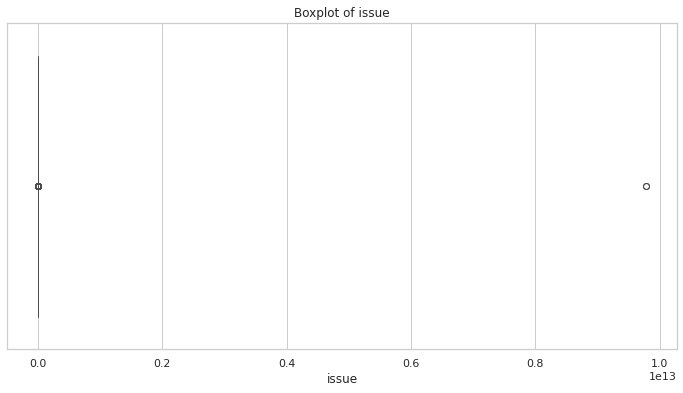

The boxplot above for 'issue' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'issue': 803



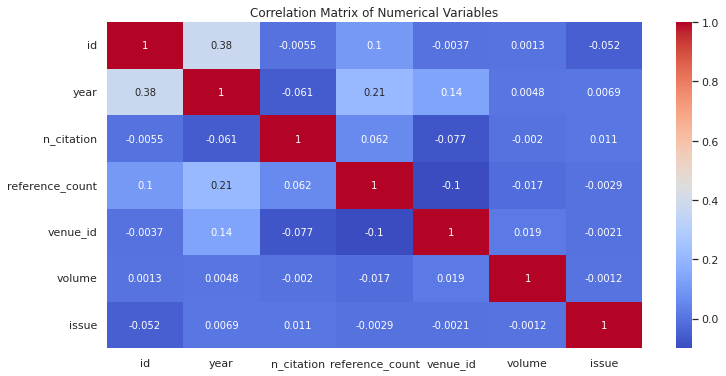

The correlation matrix above shows the correlation coefficients between numerical variables. High correlations may indicate multicollinearity.
Number of duplicate rows: 0
There are no duplicate rows in the dataset.

Categorical Variable 'title' has 48920 unique values.
'title' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'author_name' has 37807 unique values.
'author_name' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'author_org' has 36721 unique values.
'author_org' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'author_id' has 37794 unique values.
'author_id' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'doc_type' has 6 unique values.
Unique values in 'doc_type': ['Conference' nan 'Journal' 

In [15]:
perform_eda(df)

# Handling the Noise

In [22]:
def clean_data(df):
    """
    Cleans the dataset by removing rows with missing values and handling duplicates and outliers.

    Parameters:
    - df (pd.DataFrame): The DataFrame to clean.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """
    df_cleaned = df.copy()

    # Remove rows with any missing values
    print("Removing rows with missing values...")
    initial_row_count = df_cleaned.shape[0]
    df_cleaned = df_cleaned.dropna()
    final_row_count = df_cleaned.shape[0]
    rows_removed = initial_row_count - final_row_count
    print(f"Removed {rows_removed} rows due to missing values.")

    # Remove duplicates
    print("\nRemoving duplicate rows...")
    initial_row_count = df_cleaned.shape[0]
    df_cleaned = df_cleaned.drop_duplicates()
    final_row_count = df_cleaned.shape[0]
    duplicates_removed = initial_row_count - final_row_count
    print(f"Removed {duplicates_removed} duplicate rows.")

    # Handle outliers in numerical columns by removing them
    print("\nHandling outliers...")
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            print(f"No variation in '{col}'; skipping outlier handling.")
            continue
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove rows with outliers
        outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
        num_outliers = outliers.shape[0]
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        print(f"Removed {num_outliers} outliers from '{col}'.")

    # Handle inconsistencies in categorical variables
    print("\nHandling inconsistencies in categorical variables...")
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        # Convert to lowercase and strip whitespaces
        df_cleaned[col] = df_cleaned[col].str.lower().str.strip()
        print(f"Standardized text in '{col}' by converting to lowercase and stripping whitespaces.")

    print("\nData cleaning completed.")

    # Print unique values of each column to verify
    print("\nUnique values in each column after cleaning:")
    for col in df_cleaned.columns:
        num_unique_values = df_cleaned[col].nunique()
        print(f"Column '{col}' has {num_unique_values} unique values.")

    return df_cleaned

In [23]:
df_cleaned = clean_data(df)

Removing rows with missing values...
Removed 38168 rows due to missing values.

Removing duplicate rows...
Removed 0 duplicate rows.

Handling outliers...
Removed 2010 outliers from 'id'.
Removed 452 outliers from 'year'.
Removed 870 outliers from 'n_citation'.
Removed 288 outliers from 'reference_count'.
Removed 803 outliers from 'venue_id'.
Removed 597 outliers from 'volume'.
Removed 177 outliers from 'issue'.

Handling inconsistencies in categorical variables...
Standardized text in 'title' by converting to lowercase and stripping whitespaces.
Standardized text in 'author_name' by converting to lowercase and stripping whitespaces.
Standardized text in 'author_org' by converting to lowercase and stripping whitespaces.
Standardized text in 'author_id' by converting to lowercase and stripping whitespaces.
Standardized text in 'doc_type' by converting to lowercase and stripping whitespaces.
Standardized text in 'references' by converting to lowercase and stripping whitespaces.
Standardi

In [24]:
# Saving the cleaned dataset to a new CSV file
output_file_path = '/home/ashu/CSE_558_Project/data/cleaned_data.csv'
df_cleaned.to_csv(output_file_path, index=False)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 5576 entries, 695181 to 4741130
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5576 non-null   int64  
 1   title            5576 non-null   object 
 2   year             5576 non-null   float64
 3   author_name      5576 non-null   object 
 4   author_org       5576 non-null   object 
 5   author_id        5576 non-null   object 
 6   n_citation       5576 non-null   float64
 7   doc_type         5576 non-null   object 
 8   reference_count  5576 non-null   float64
 9   references       5576 non-null   object 
 10  venue_id         5576 non-null   float64
 11  venue_name       5576 non-null   object 
 12  venue_type       5576 non-null   object 
 13  doi              5576 non-null   object 
 14  keyword          5576 non-null   object 
 15  volume           5576 non-null   float64
 16  issue            5576 non-null   flo

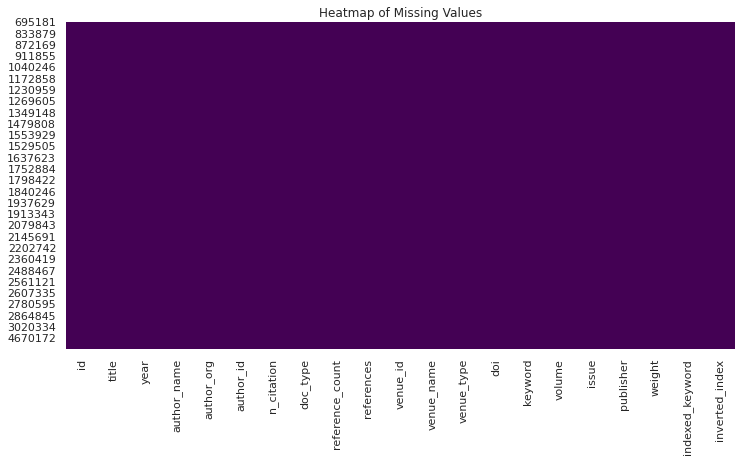

The heatmap above shows the distribution of missing values across the dataset. Columns with more missing values will have more yellow lines.


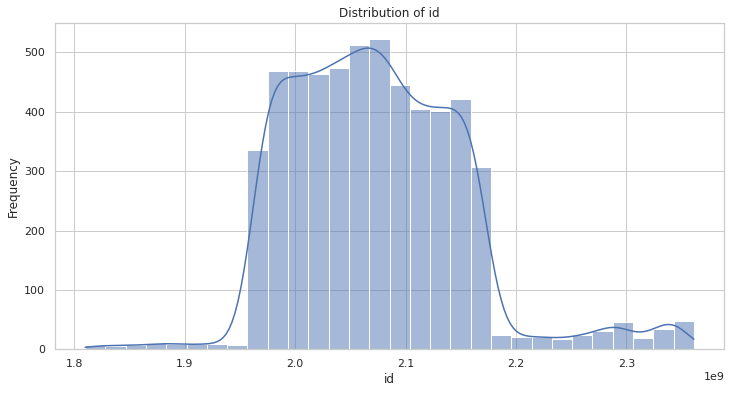

The histogram above shows the distribution of 'id'. Skewness or irregularities may indicate noise.


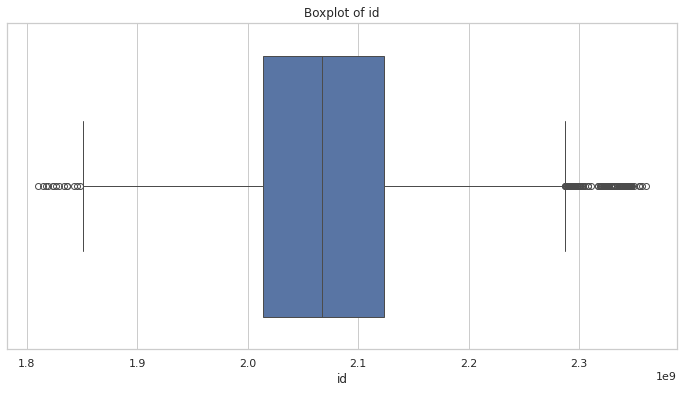

The boxplot above for 'id' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'id': 163



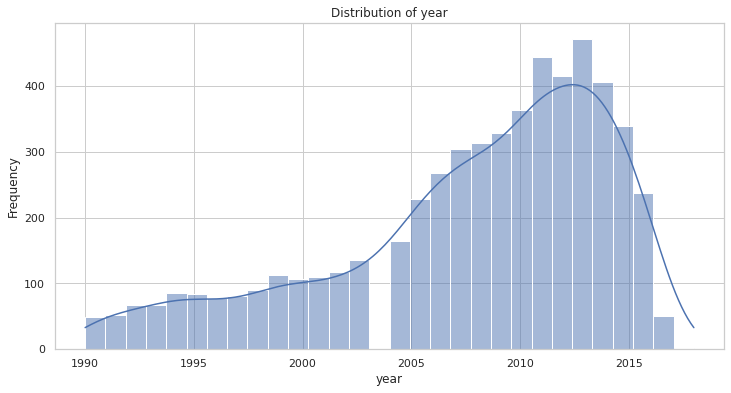

The histogram above shows the distribution of 'year'. Skewness or irregularities may indicate noise.


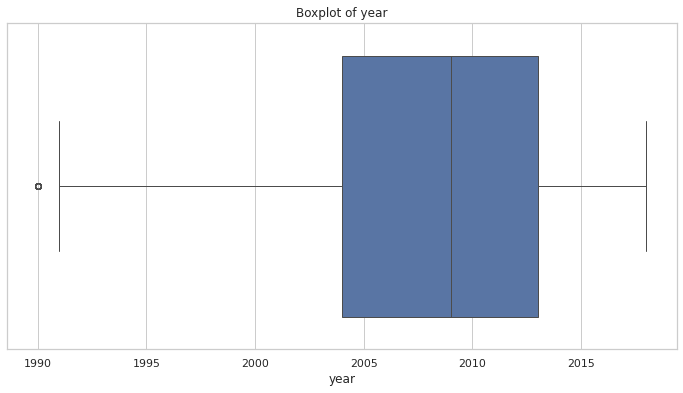

The boxplot above for 'year' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'year': 49



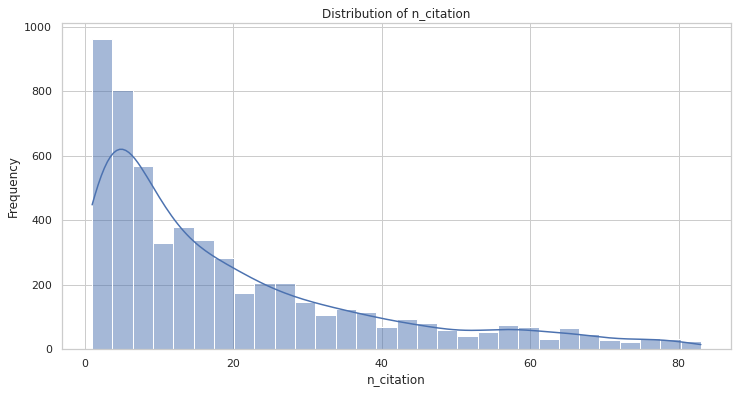

The histogram above shows the distribution of 'n_citation'. Skewness or irregularities may indicate noise.


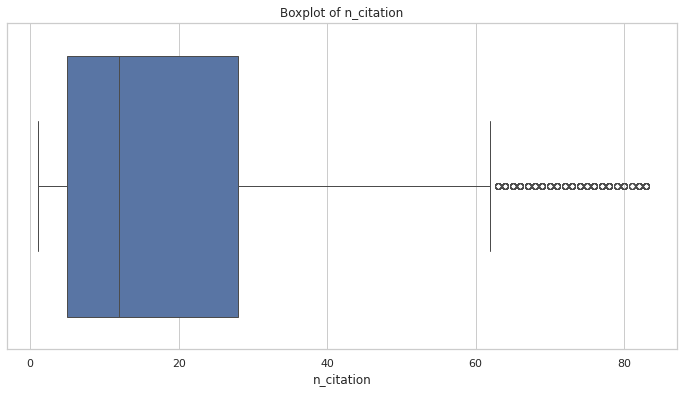

The boxplot above for 'n_citation' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'n_citation': 269



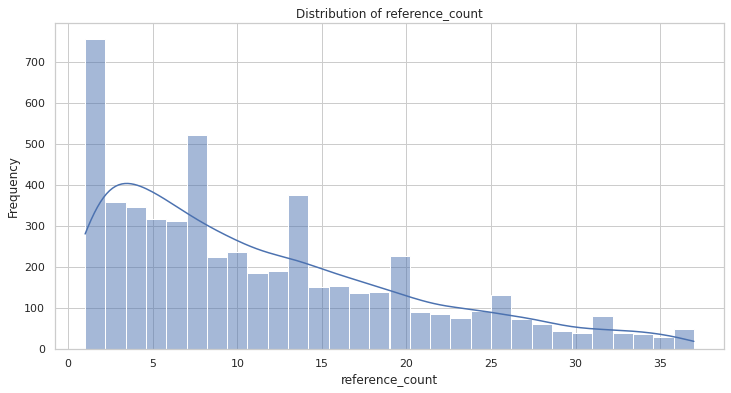

The histogram above shows the distribution of 'reference_count'. Skewness or irregularities may indicate noise.


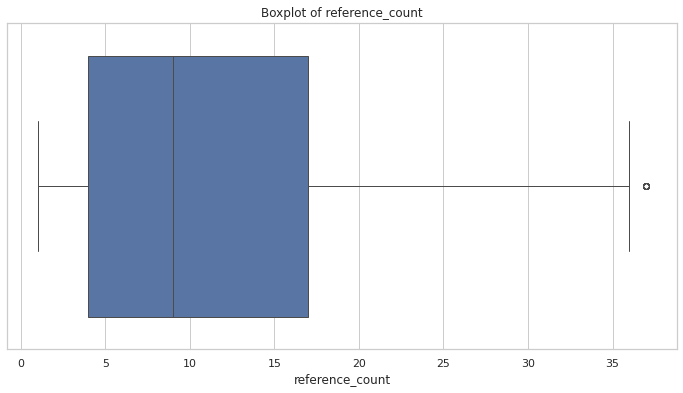

The boxplot above for 'reference_count' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'reference_count': 15



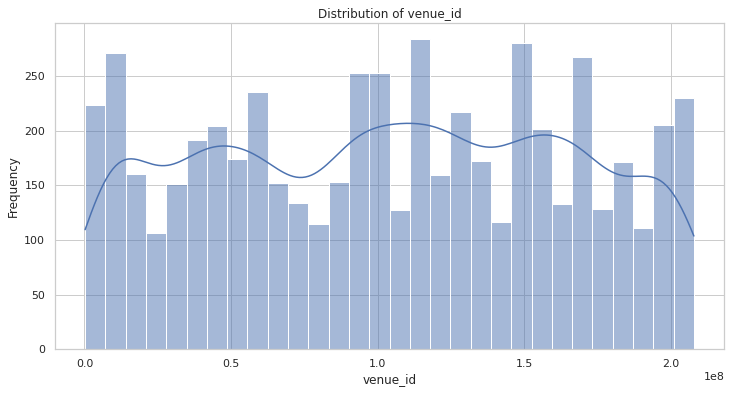

The histogram above shows the distribution of 'venue_id'. Skewness or irregularities may indicate noise.


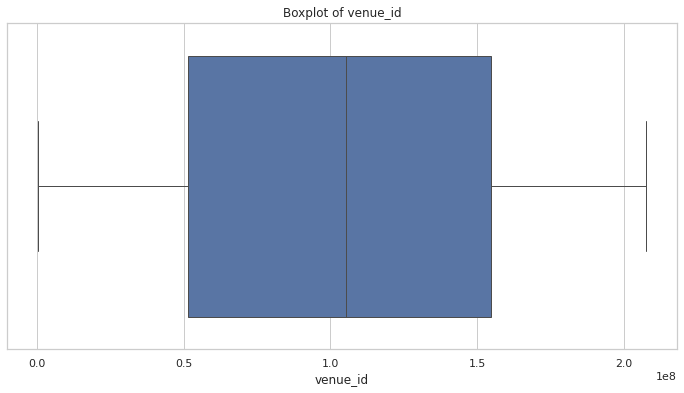

The boxplot above for 'venue_id' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'venue_id': 0



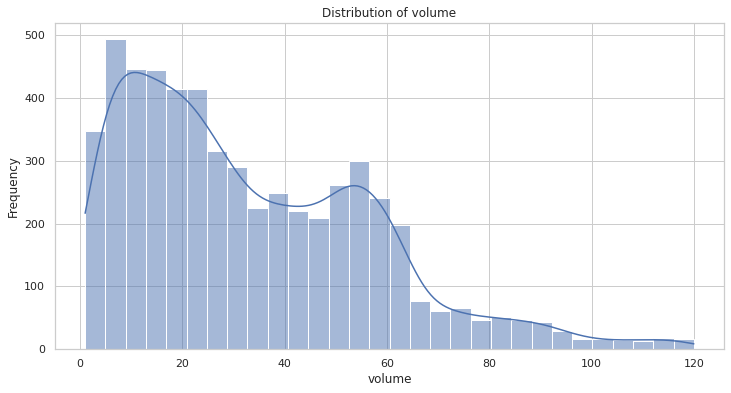

The histogram above shows the distribution of 'volume'. Skewness or irregularities may indicate noise.


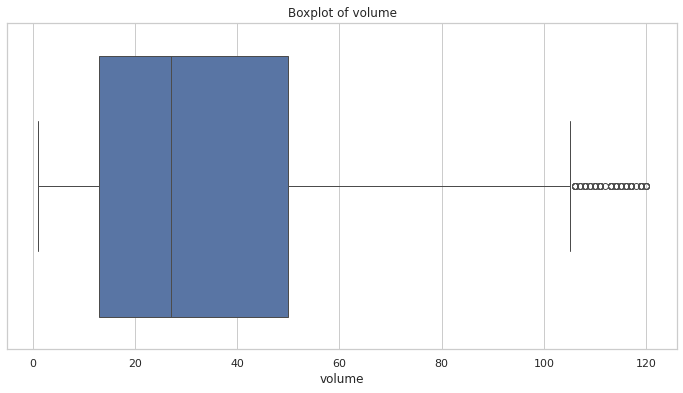

The boxplot above for 'volume' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'volume': 60



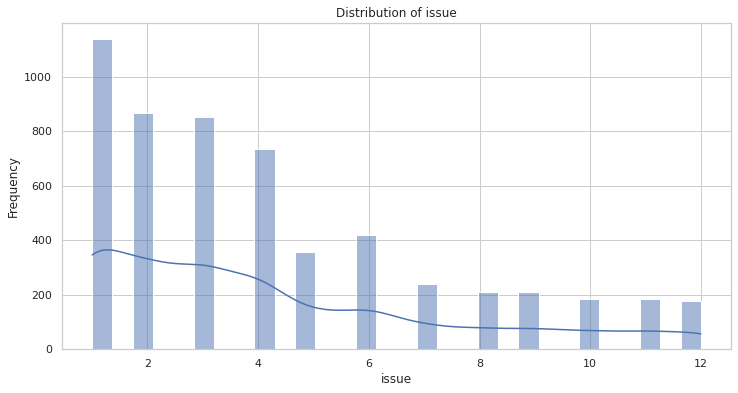

The histogram above shows the distribution of 'issue'. Skewness or irregularities may indicate noise.


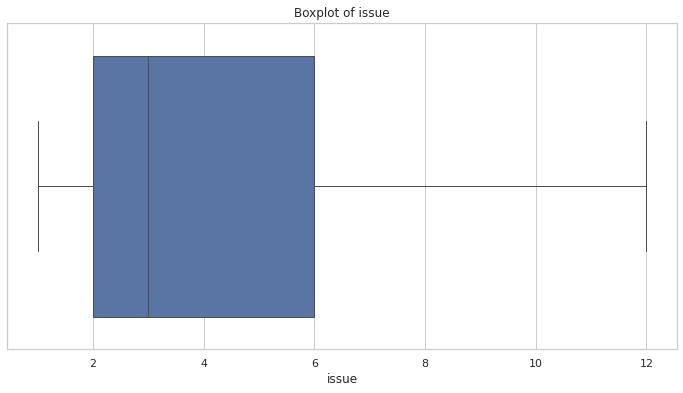

The boxplot above for 'issue' helps identify outliers. Points outside the whiskers are potential outliers.
Number of outliers in 'issue': 0



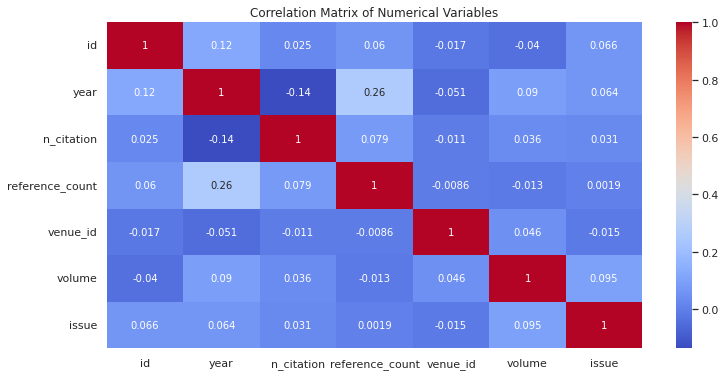

The correlation matrix above shows the correlation coefficients between numerical variables. High correlations may indicate multicollinearity.
Number of duplicate rows: 0
There are no duplicate rows in the dataset.

Categorical Variable 'title' has 5576 unique values.
'title' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'author_name' has 5330 unique values.
'author_name' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'author_org' has 5313 unique values.
'author_org' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'author_id' has 5331 unique values.
'author_id' has many unique values; we should consider checking for inconsistencies or encoding if necessary.

Categorical Variable 'doc_type' has 2 unique values.
Unique values in 'doc_type': ['journal' 'patent']

Categorica

In [25]:
perform_eda(df_cleaned)

In [27]:
# print rows having the substring nan in any column
print(df_cleaned[df_cleaned.isin(['nan']).any(axis=1)])
# Empty

Empty DataFrame
Columns: [id, title, year, author_name, author_org, author_id, n_citation, doc_type, reference_count, references, venue_id, venue_name, venue_type, doi, keyword, volume, issue, publisher, weight, indexed_keyword, inverted_index]
Index: []

[0 rows x 21 columns]


# Data Cleaned!!

In [34]:
# print col datatypes
df_cleaned.dtypes

id                   int64
title               object
year               float64
author_name         object
author_org          object
author_id           object
n_citation         float64
doc_type            object
reference_count    float64
references          object
venue_id           float64
venue_name          object
venue_type          object
doi                 object
keyword             object
volume             float64
issue              float64
publisher           object
weight              object
indexed_keyword     object
inverted_index      object
dtype: object